# Spatial Analysis of Chicago Crime Data

In this notebook, I go over different spatial analysis techniques and principles and apply them to the open-source Chicago Crime dataset.

### Table of Contents

1. [Introduction](#introduction)
2. [Data Preprocessing](#data-preprocessing)
3. [Spatial Autocorrelation Analysis](#spatial-autocorrelation-analysis)
> 3.1 [Choropleth Mapping](#choropleth-mapping)  
> 3.2 [Global Spatial Autocorrelation](#global-spatial-autocorrelation)  
> 3.3 [Local Spatial Autocorrelation](#local-spatial-autocorrelation)  
> 3.4 [Kernel Density Estimation](#kernel-density-estimation-kde)
4. [Final Thoughts](#final-thoughts)

----------
### Introduction

**Spatial analysis** is a broad term that encompasses different processes and methods that can be applied to spatial data in order to extract insights from it. To put it another way, it uses data analysis and data science techniques combined with specific domain knowledge on data that has an intrinsic spatial ordering, like geographical data.

Moreover, many real-life processes are heavily influenced by geography, which in turn means that many processes can be modeled and studied more precisely by taking geography into account. For example:

* An individual's everyday decisions, like where to eat on a given night, depend not only on their food cravings, but on where they are in the first place and the restaurants nearby. Keeping all other variables the same, closer places are more preferable, and places outside a certain distance radius are out of consideration

* Countries with access to navigable coasts and rivers often have more robust trade networks and industrial development than landlocked countries

* House prices on cities depend strongly on their location, too. Proximity to good schools, public transportation, points of interest like beaches or cultural centers, as well as membership to low-crime neighborhoods can substantially increase a property's value, while nearby environmental risks (like landslide zones, highly-polluted air or earthquake fault lines) may reduce it

One of the key topics in spatial analysis is the study of **spatial autocorrelation**. Some of the questions that SA can answer about a geographical dataset are:
* Do the data points tend to cluster more than what you would expect at random? if so, where are these clusters or hotspots located?
* Is the clustering observed in the dataset statistically significant?

In this notebook, I aim to cover some of the key methods used in **spatial autocorrelation** and apply them on the publicly-available [Chicago Crime dataset](https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q/about_data), which is maintained by the city's police department and contains anonymized reported crime incidents within the city for the past year, as well as approximate locations.

Most of the inspiration for this mini-project came from the open-source book [Geographic Data Science with Python](https://geographicdata.science/book/intro.html), which I highly recommend.

------------
### Data Wrangling

The first step is to download the dataset from the website (I chose to do this in a .csv format). After this, it's time to do some exploratory data analysis to get to know the dataset better, while preparing it for the actual SA techniques in the next section.

I'll be using `polars` for the initial EDA before moving on to the `geopandas` library for more dedicated spatial operations.

In [2]:
import polars as pl


# read data and format columns
data = pl.read_csv('data/chicago_crime_data.csv')
data = data.with_columns(
    pl.col("DATE  OF OCCURRENCE").str.strptime(
        pl.Datetime, 
        format="%m/%d/%Y %I:%M:%S %p"
    )
)

# get initial statistics
print(f"Dataset initial rows and cols: {data.shape}")
print("Earliest date in dataset: ", data["DATE  OF OCCURRENCE"].min())
print("Latest date in dataset: ", data["DATE  OF OCCURRENCE"].max())

# see first 5 rows
data.head()

Dataset initial rows and cols: (245851, 17)
Earliest date in dataset:  2024-06-14 05:01:00
Latest date in dataset:  2025-06-13 00:00:00


CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
str,datetime[μs],str,str,str,str,str,str,str,i64,i64,str,i64,i64,f64,f64,str
"""JJ237801""",2025-04-30 14:30:00,"""004XX W 66TH ST""","""1320""","""CRIMINAL DAMAGE""","""TO VEHICLE""","""VACANT LOT / LAND""","""N""","""N""",722,6,"""14""",1174537,1861156,41.774406,-87.635727,"""(41.774405884, -87.635727351)"""
"""JH508440""",2024-11-14 18:15:00,"""013XX W Erie St""","""1320""","""CRIMINAL DAMAGE""","""TO VEHICLE""","""STREET""","""N""","""N""",1215,1,"""14""",1167198,1904473,41.893432,-87.661389,"""(41.893432241, -87.661388702)"""
"""JH404058""",2024-08-27 09:00:00,"""091XX S COMMERCIAL AVE""","""0810""","""THEFT""","""OVER $500""","""RESTAURANT""","""N""","""N""",423,10,"""06""",1197730,1845034,41.729618,-87.551245,"""(41.729618252, -87.551244573)"""
"""JJ255439""",2025-03-04 09:00:00,"""053XX N SHERIDAN RD""","""1110""","""DECEPTIVE PRACTICE""","""BOGUS CHECK""","""OTHER (SPECIFY)""","""N""","""N""",2023,48,"""11""",1168675,1935712,41.979122,-87.655057,"""(41.97912164, -87.655056515)"""
"""JH547886""",2024-12-18 19:40:00,"""002XX W LOWER WACKER DR""","""2170""","""NARCOTICS""","""POSSESSION OF DRUG EQUIPMENT""","""STREET""","""Y""","""N""",122,42,"""18""",1174608,1902122,41.886818,-87.634245,"""(41.886818499, -87.634244983)"""


In [3]:
# check nulls
data.null_count()

CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,827,0,0,0,0,0,93,93,93,93,93


The dataset contains over 240K records of reported crimes, ranging from June 14th, 2024 to June 13 2025. The key columns that we'll use to derive geographical location are `LATITUDE` and `LONGITUDE`, so it's necessary to drop any rows that have nulls in any of those fields.

First, we will explore the `PRIMARY DESCRIPTION` column, which contains a basic description of the type of crime committed.

In [4]:
crime_counts = data.select(
    pl.col(' PRIMARY DESCRIPTION').value_counts()
).unnest(
    ' PRIMARY DESCRIPTION'
).sort(
    "count", 
    descending=True
)

print(
    f"Unique crimes: {crime_counts[" PRIMARY DESCRIPTION"].unique().to_list()}"
)
crime_counts

Unique crimes: ['CRIMINAL DAMAGE', 'BATTERY', 'OBSCENITY', 'KIDNAPPING', 'PUBLIC INDECENCY', 'LIQUOR LAW VIOLATION', 'OTHER NARCOTIC VIOLATION', 'PUBLIC PEACE VIOLATION', 'THEFT', 'STALKING', 'CRIMINAL SEXUAL ASSAULT', 'GAMBLING', 'WEAPONS VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'CRIMINAL TRESPASS', 'PROSTITUTION', 'SEX OFFENSE', 'CONCEALED CARRY LICENSE VIOLATION', 'HUMAN TRAFFICKING', 'ROBBERY', 'HOMICIDE', 'OTHER OFFENSE', 'BURGLARY', 'NARCOTICS', 'MOTOR VEHICLE THEFT', 'NON-CRIMINAL', 'ASSAULT', 'ARSON', 'INTERFERENCE WITH PUBLIC OFFICER', 'DECEPTIVE PRACTICE', 'INTIMIDATION']


PRIMARY DESCRIPTION,count
str,u32
"""THEFT""",58838
"""BATTERY""",43724
"""CRIMINAL DAMAGE""",26834
"""ASSAULT""",22235
"""MOTOR VEHICLE THEFT""",18903
…,…
"""HUMAN TRAFFICKING""",23
"""GAMBLING""",19
"""PUBLIC INDECENCY""",12


The dataset contains 31 different types of main crimes, with the most common ocurrence being theft, followed by battery and criminal damage. We have a very wide variety of crimes, ranging from very serious crimes (like homicide or kidnapping) to minor offenses (like gambling or liquor law violations), and it doesn't make a lot of sense to examine them together as if they were of the same type.

To solve this issue, the dataset is filtered to keep only crimes that have at least 50 ocurrences within the dataset, and that relate to either violent actions, or actions that threaten private or public property. This is done to improve the purity of the dataset and to prepare the data for the upcoming analysis, but it's not to say the crimes being discarded aren't wrong.

In [5]:
initial_rows = len(data)
# filter data by type of main crime
serious_crimes = [
    "HOMICIDE",
    "CRIMINAL SEXUAL ASSAULT",
    "SEX OFFENSE",
    "ROBBERY",
    "BATTERY",
    "ASSAULT",
    "ARSON",
    "KIDNAPPING",
    "WEAPONS VIOLATION",
    "HUMAN TRAFFICKING",
    "OFFENSE INVOLVING CHILDREN",
    "STALKING",
    "INTIMIDATION",
    "BURGLARY",
    "THEFT",
    "MOTOR VEHICLE THEFT",
    "CRIMINAL DAMAGE",
    "CRIMINAL TRESPASS",
    "NARCOTICS",
]
data = data.filter(
    pl.col(' PRIMARY DESCRIPTION').is_in(serious_crimes)
)

# filter data of rare types of crimes
common_crimes = crime_counts.filter(
    pl.col("count") >= 50
)[' PRIMARY DESCRIPTION'].to_list()
data = data.filter(
    pl.col(' PRIMARY DESCRIPTION').is_in(common_crimes)
)

# check statistics
print(f"Dataset new rows: {len(data)}")
print(
    f"Loss of rows after filtering operation: {initial_rows - len(data)}"
)
print(
    f"New unique crimes: {data[" PRIMARY DESCRIPTION"].unique().to_list()}"
)

Dataset new rows: 211816
Loss of rows after filtering operation: 34035
New unique crimes: ['BATTERY', 'WEAPONS VIOLATION', 'HOMICIDE', 'ROBBERY', 'CRIMINAL SEXUAL ASSAULT', 'ASSAULT', 'BURGLARY', 'STALKING', 'THEFT', 'NARCOTICS', 'CRIMINAL TRESPASS', 'KIDNAPPING', 'MOTOR VEHICLE THEFT', 'SEX OFFENSE', 'OFFENSE INVOLVING CHILDREN', 'INTIMIDATION', 'ARSON', 'CRIMINAL DAMAGE']


Now, the dataset is filtered to keep a similar type of serious crimes, that occured at least 50 times across the entire year. This reduces the total types of crimes from 31 initially to just 18. For more specialized applications, the dataset could be further reduced by considering the secondary descriptions of the crime, and discard petty theft cases under $100, for example. However, for this application this isn't necessary.

The dataset also contains the approximate time of ocurrence of the crime (`DATE  OF OCCURRENCE`), which is expressed in local Chicago time. Let's explore this next:

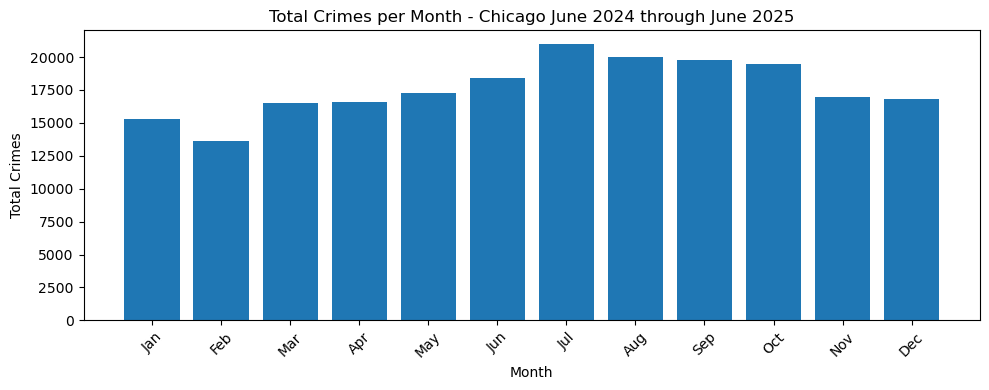

In [6]:
import calendar
import matplotlib.pyplot as plt


# ----------
# Check total crime events per month
# ----------

# extract month number and save to new column
month_map = {i: calendar.month_abbr[i] for i in range(1, 13)}
# extract month number from datetime
data = data.with_columns([
    pl.col('DATE  OF OCCURRENCE').dt.month().alias("month"),
])
# count total crimes by month number
monthly_counts = data.select(
    pl.col('month').value_counts()
).unnest(
    'month'
).sort(
    'month',
    descending=False
)
# map month number to month name
monthly_counts = monthly_counts.with_columns([
    pl.col("month").map_elements(
          lambda m: month_map.get(m, "Unknown"),
          return_dtype=pl.Utf8
    ).alias("month")
])
monthly_counts

# plot
monthly_pd = monthly_counts.to_pandas()  # transform to pandas for easier handling
plt.figure(figsize=(10, 4))
plt.bar(monthly_pd["month"], monthly_pd["count"])
plt.xticks(rotation=45)
plt.title("Total Crimes per Month - Chicago June 2024 through June 2025")
plt.xlabel("Month")
plt.ylabel("Total Crimes")
plt.tight_layout()
plt.show()

Looking at the total crimes at the level of months, we can see that July is the month with the highest total crimes, and more generally that the period from July to October was the period with the highest crimes count of the year. Conversely, February stands out as the month with the highest total crimes by a wide margin.

We can also examine the data in terms of frequency per weekday and time of the day:

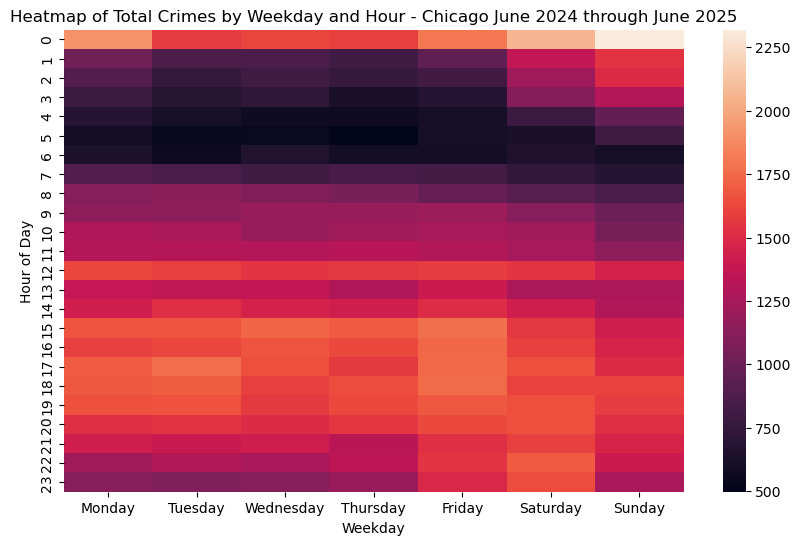

In [7]:
import seaborn as sns


# ----------
# Check total crime events per weekday and hour
# ----------

# use for mapping a day number to a name
day_mappings = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday"
}
# create columns to store hour of day and weekday
data = data.with_columns([
    pl.col("DATE  OF OCCURRENCE").dt.hour().alias("hour"),
    pl.col("DATE  OF OCCURRENCE").dt.weekday().alias("weekday_num"),
    pl.col("DATE  OF OCCURRENCE").dt.weekday().map_elements(
        lambda d: day_mappings.get(d, "Unknown"), return_dtype=pl.Utf8
    ).alias("weekday_name")
])
# group data by weekday and hour
heatmap_data = (
    data.group_by(["hour", "weekday_name"])
           .agg(pl.len().alias("count"))
           .pivot(values="count", index="hour", on="weekday_name")
           .fill_null(0)
)
# plot
heatmap_pd = heatmap_data.to_pandas().set_index("hour")  # convert to pandas
heatmap_pd.sort_values(
    by="hour", 
    ascending=True, 
    inplace=True
)
weekday_order = list(calendar.day_name)  # order weekdays properly
heatmap_pd = heatmap_pd[weekday_order]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pd, cmap="rocket", annot=False)
plt.title("Heatmap of Total Crimes by Weekday and Hour - Chicago June 2024 through June 2025")
plt.xlabel("Weekday")
plt.ylabel("Hour of Day")
plt.show()


The heatmap above contains plenty of interesting information, let's break it down:

* The color variation in the horizontal direction is very slight for most of the hours, which indicates that generally there is the same criminal activity regardless of the day of the week.

* The most active moment of the week for crime on the heatmap is clearly distinguishable as the transition from Saturday to Sunday from around 10pm to 1am of the next day, followed by the same time period from Friday to Saturday. One possible explanation for this is that many people use these times to go outside and engage on social activities while they're off from their weekday jobs, which for criminals increases the number of potential victims on the streets. Also, it's dark during those times, which is obviously more convenient for criminals who don't want to be caught in their activities.

* The least active moments of the week for crime are from around 3am to 7am, consistently every weekday (sort of). This is probably explained by the fact that by those times most people (both civilians and criminals) are asleep on their homes, not engaging in activities.

The time analysis part of this dataset has been very interesting, but let's get back to the spatial data. Using the timestamp of the crime would be great for conducting a hybrid spatial time analysis, but unfortunately that's out of this project's scope.

With this in mind, and after checking the other column definitions in the website, several columns can be dropped, as well as intermediate objects that have been used for obtaining the previous plots.

In [8]:
import gc

# drop python objects that aren't needed anymore (save memory)
del (
    crime_counts,
    serious_crimes,
    common_crimes,
    month_map,
    monthly_counts,
    monthly_pd,
    day_mappings,
    heatmap_data,
    heatmap_pd,
    weekday_order
)
gc.collect()  # make sure memory is released

initial_shape = data.shape
# drop rows with nulls in geolocation
data = data.drop_nulls(
    ["LATITUDE", "LONGITUDE"]
)

# drop unnecesary columns
data = data.drop(
    [
        'CASE#',  # police ID for case number
        'BLOCK',  # name of the block for event 
        ' IUCR',  # another crime-related code
        ' SECONDARY DESCRIPTION',  # detailed description of crime
        ' LOCATION DESCRIPTION',
        'ARREST',  # whether an arrest was made
        'DOMESTIC',  # whether the crime was domestic
        'BEAT',  # ID for police geographic area within a police district
        'WARD',  # the city council district
        'FBI CD',  # FBI crime classification
        'X COORDINATE',  # x location using State Plane Illinois East NAD 1983 projection
        'Y COORDINATE',
        'LOCATION',   # lat-lon tuple
        'DATE  OF OCCURRENCE',  # timestamp of crime
        ' PRIMARY DESCRIPTION',  # we already used this column
        # used for intermediate time calculations
        'month',
        'hour',
        'weekday_num',
        'weekday_name'
    ]
)
# rename columns to lowercase
data = data.rename({
    'LATITUDE': 'latitude',
    'LONGITUDE': 'longitude'
})

# check new dataset
print(f"Initial dataset rows and cols: {initial_shape}")
print(f"Dataset new rows and cols: {data.shape}")
data.tail()

Initial dataset rows and cols: (211816, 21)
Dataset new rows and cols: (211754, 2)


latitude,longitude
f64,f64
41.805869,-87.585195
41.809125,-87.631907
41.792033,-87.617527
41.791763,-87.657241
42.009258,-87.709223


Now the dataset has a more compact form, keeping only the location of the recorded serious crimes.

For some of the spatial autocorrelation methods, it's more convenient to have a previous division of the city by subregions, and to group the total count of crimes by these subregions. The best practice is to use the city's **community area** mappings, which is a geographical subdivision of a city based on lasting factors like cultural identity and historical background. These will have to be fetched elsewhere and assigned to each crime report observation based on the latitude and longitude of the report.

Note that the dataset already offered an ordering of the crimes by **Ward**, but this is more of a political arrangement of the city for voting purposes and is subject to changes every few years, which makes it a less representative choice for generating the subdivions.
For more information, please check [this source](https://www.chicagohistory.org/mapping-chicago-and-beyond-what-are-chicagos-neighborhoods-community-areas-and-wards/). 

The mappings for the Chicago community areas can be downloaded from the [Chicago Data Portal](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-Map/cauq-8yn6), preferrably in the form of a `GeoJSON` file.

For the following operations involving geospatial data, `GeoPandas` is a more suitable choice than `polars`.

Let's first load the community area boundaries to a dataframe, and visualize them on a plot.

In [9]:
import geopandas as gpd


# load community areas to gpd df
community_areas = gpd.read_file("data/chicago_community_areas.geojson")
community_areas = community_areas.to_crs("EPSG:4326")  # use this projection so we can plot

# keep a subset of the columns
community_areas = community_areas[[
    "community",
    "area_numbe",
    "geometry"
    ]
]
community_areas.rename(
    columns={"area_numbe": "area_number"},
    inplace=True
)
community_areas.head()

,community,area_number,geometry
0,ROGERS PARK,1,"MULTIPOLYGON (((-87.65456 41.99817, -87.65574 ..."
1,WEST RIDGE,2,"MULTIPOLYGON (((-87.68465 42.01948, -87.68464 ..."
2,UPTOWN,3,"MULTIPOLYGON (((-87.64102 41.9548, -87.644 41...."
3,LINCOLN SQUARE,4,"MULTIPOLYGON (((-87.67441 41.9761, -87.6744 41..."
4,NORTH CENTER,5,"MULTIPOLYGON (((-87.67336 41.93234, -87.67342 ..."


The dataframe contains the following columns:
* `community`: The name for the community area
* `area_number`: Enumeration code for the area.
* `geometry`: the coordinates delimiting the boundaries of the community area. This is stored in the form of special **shapely.geometry** objects.

Now we can visualize the community areas by overlaying them on top of a Chicago map, and adding a pop-up to display the area name when clicked:

In [10]:
import folium


map = folium.Map(
    location=[41.8781, -87.6298],  # center map on Chicago
    zoom_start=11
)

# Loop through each community area and plot it
for _, area in community_areas.iterrows():
    simplified = area['geometry'].simplify(tolerance=0.001)

    # draw the boundaries for com area
    geo_j = folium.GeoJson(
        data=gpd.GeoSeries([simplified]).__geo_interface__,
        style_function=lambda x: {
            'fillColor': '#FFFFFF',
            'color': 'blue',
            'weight': 2,
            'fillOpacity': 0.2
        }
    )
    
    # Add popup
    geo_j.add_child(folium.Popup(area['community']))
    geo_j.add_to(map)

map

**Note**: The map may not display properly when viewing from Github.

The mappings divide Chicago in 77 different communities, which are observable on the map.
Now, the dataframe containing the crime events will be mapped to a specific community area. In geo-analysis terms, community areas are polygonal closed structures, while the crime events are points of only location and no dimension.

In [11]:
# convert polars df to pandas, then geopandas
events_data = data.to_pandas()
# create geometry from lat, lon
events_data = gpd.GeoDataFrame(
    events_data,
    geometry=gpd.points_from_xy(
        events_data["longitude"], 
        events_data["latitude"]
    ),
    crs="EPSG:4326"  # use same projection as com areas
)

# perform spatial join to map a commarea to events
events_data = gpd.sjoin(
    events_data,
    community_areas[["area_number", "geometry"]],
    how="inner",  # drop rows outside com area mappings
    predicate="within"  # event must lie within the polygon
)

# drop intermediate columns
events_data.drop(
    columns=["index_right"],
    inplace=True
)
# visualize transformation
print(f"Dataset new rows and cols: {events_data.shape}")
events_data.sample(5)

Dataset new rows and cols: (211072, 4)


,latitude,longitude,geometry,area_number
126876,41.711769,-87.636892,POINT (-87.63689 41.71177),73
9882,41.793245,-87.654853,POINT (-87.65485 41.79324),67
90125,42.014494,-87.690228,POINT (-87.69023 42.01449),2
26513,41.949370,-87.705447,POINT (-87.70545 41.94937),16
121576,41.879465,-87.748273,POINT (-87.74827 41.87946),25


After the transformation, the events dataframe has the new additional columns:
* `geometry`: A geographic coordinate indicating the lcoation of the event.
* `area_number`: the community area code where the event happened.

-------------
### Spatial Autocorrelation Analysis

After the initial preprocessing operations, everything is set to start with the SA analysis.

#### Choropleth Mapping

The first, most simple way to get a sense of SA in the dataset is to do a **choropleth mapping** of the data. This is basically a color-coded graph showing the distribution of the variable of interest within the map.

In our specific case, this involves firstly counting the total crimes per community area, then 'categorizing' or creating bins for the distribution of total crimes, and plotting them on a map. If spatial autocorrelation exists, we would expect to see clearly-differentiable multi-area sections of the city with high crime numbers, and other regions with low numbers.

In [12]:
# ----------
# Map total crimes per comm area name
# ----------

# get counts of crimes per comm area
crime_counts = events_data["area_number"].value_counts().reset_index()
crime_counts.columns = ["area_number", "total_crimes"]

# merge to get comm area names
crime_counts = crime_counts.merge(
    community_areas,
    on="area_number",
    how="inner"
)
# turn into a gpd
crime_counts = gpd.GeoDataFrame(
    crime_counts,
    geometry="geometry",
    crs="EPSG:4326"
)
# sort by crimes total
crime_counts = crime_counts.sort_values("total_crimes", ascending=False)
crime_counts.head()

,area_number,total_crimes,community,geometry
0,25,10997,AUSTIN,"MULTIPOLYGON (((-87.78942 41.91751, -87.78927 ..."
1,8,9287,NEAR NORTH SIDE,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ..."
2,28,9207,NEAR WEST SIDE,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ..."
3,32,7491,LOOP,"MULTIPOLYGON (((-87.60949 41.8894, -87.60949 4..."
4,43,7222,SOUTH SHORE,"MULTIPOLYGON (((-87.54398 41.75515, -87.544 41..."


In order to get a fair comparison between community areas of different sizes, we not only want to consider total crimes, but crime events per square meter. To do this, first we obtain the total area for each polygon, then use it to divide the value we've already obtained for total crimes.

**Note**: An equally-valid approach would be to divide by the total population of each area.

Obtaining the total physical area enclosed by a polygonal shape of geographical coordinates is something worth taking a step back and considering.

Firstly, it's important to understand **coordinate systems**. These can be either: 
* _degree-based_: It takes into account the curvature of the Earth and maps locations using latitudes and longitudes
* _projected_: These CS "flatten" the Earth and make it length-based. The shape of the Earth is almost a perfect sphere, and mathematically there's no way of laying out a sphere's surface on a plane without distorting it (if you don't believe me, watch [this video](https://www.youtube.com/watch?v=kIID5FDi2JQ)). In other words, all projected CS are wrong, but some are useful depening on what you want to do with them

So far, we've worked with the CS [EPSG 4326](https://epsg.io/4326). This is a degree-based system, meaning we need to find a CS that has minimum distortion in the Chicago-Illinois area. 
One such system is [EPSG 3435](https://epsg.io/3435), which is projected and has minimum distortion around our target area. According to its web reference, it's accurate to about 2m in the Illinois area, which means that any projected coordinate here is distorted at most 2 meters from its real location due to the effects of projection distortion. Considering how big an entire state is, this is a pretty good deal.

In `geopandas`, we can easily change the CS into a projected system, and then use the _geometry.area_ attribute to obtain each subregion's total area.

In [13]:
# calculate areas in a separate df, then merge to original df
projected_com_areas = crime_counts.to_crs(epsg=3435)
projected_com_areas["area_sqm"] = projected_com_areas.geometry.area
projected_com_areas["area_sqm"] = (  # turn from sq feet into sq meters
    projected_com_areas.geometry.area * (0.3048 ** 2)
)
crime_counts = crime_counts.merge(
    right=projected_com_areas[["area_number", "area_sqm"]],
    how='inner',
    on='area_number'
)
# compute total crimes over total area
crime_counts["crime_density"] = (
    crime_counts["total_crimes"] / crime_counts["area_sqm"]
)

# check total area for Chicago
print(
    "Total area for Chicago in sq kilometers: "
    f"{round(crime_counts["area_sqm"].sum() / 1e6, 2)}"
)
crime_counts.head()

Total area for Chicago in sq kilometers: 598.14


,area_number,total_crimes,community,geometry,area_sqm,crime_density
0,25,10997,AUSTIN,"MULTIPOLYGON (((-87.78942 41.91751, -87.78927 ...",1.851132e+07,0.000594
1,8,9287,NEAR NORTH SIDE,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...",7.123424e+06,0.001304
2,28,9207,NEAR WEST SIDE,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...",1.472443e+07,0.000625
3,32,7491,LOOP,"MULTIPOLYGON (((-87.60949 41.8894, -87.60949 4...",4.304715e+06,0.001740
4,43,7222,SOUTH SHORE,"MULTIPOLYGON (((-87.54398 41.75515, -87.544 41...",7.600650e+06,0.000950


As a sanity check, we also compute the total area for the Chicago by adding up the areas of all community areas in the dataset, and obtain 598.14 square kilometers. This is 98.7% accurate when compared to the [official reference](https://en.wikipedia.org/wiki/Geography_of_Chicago#:~:text=the%20City%20of%20Chicago%20has%20a%20total%20area%20of%20606.1%C2%A0km2%20(234.0%C2%A0sq%C2%A0mi).%20588.3%C2%A0km2%20(227.1%C2%A0sq%C2%A0mi)%20of%20it%20is%20land%20and%2017.8%20square%20kilometres%20(6.9%C2%A0sq%C2%A0mi)%20of%20it%20is%20water.) of 606.1 km2, which means we're on the right track.

Several approaches exist in order to categorize a numerical variable into bins. In this case, we choose a simple approach of dividing the data into 5 equally-represented groups, interpretable in the following manner:
* First bin: Very low crime
* Second bin: Low crime
* Third bin: Medium crime
* Fourth bin: High crime
* Fourth quartile: Very high crime

This categorizations are, of course, relative to the same city. In reality, we don't have enough information to judge whether crime is objectively high or low in any given point.

In [14]:
crime_counts.columns

Index(['area_number', 'total_crimes', 'community', 'geometry', 'area_sqm',
       'crime_density'],
      dtype='object')

In [15]:
import pandas as pd


bin_labels = [
    'Very low',
    'Low',
    'Medium',
    'High',
    'Very High'
]
# split total_crimes into quartiles
crime_counts["total_crimes_bin"] = (
    pd.qcut(
        crime_counts["total_crimes"], 
        q=5, 
        labels=bin_labels
    )
)
# split crime density into cuartiles
crime_counts["crime_density_bin"] = (
    pd.qcut(
        crime_counts["crime_density"], 
        q=5, 
        labels=bin_labels
    )
)
crime_counts.head()

,area_number,total_crimes,community,geometry,area_sqm,crime_density,total_crimes_bin,crime_density_bin
0,25,10997,AUSTIN,"MULTIPOLYGON (((-87.78942 41.91751, -87.78927 ...",1.851132e+07,0.000594,Very High,High
1,8,9287,NEAR NORTH SIDE,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...",7.123424e+06,0.001304,Very High,Very High
2,28,9207,NEAR WEST SIDE,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...",1.472443e+07,0.000625,Very High,Very High
3,32,7491,LOOP,"MULTIPOLYGON (((-87.60949 41.8894, -87.60949 4...",4.304715e+06,0.001740,Very High,Very High
4,43,7222,SOUTH SHORE,"MULTIPOLYGON (((-87.54398 41.75515, -87.544 41...",7.600650e+06,0.000950,Very High,Very High


Now is time to visualize the results for both total crimes and crime density on the map.

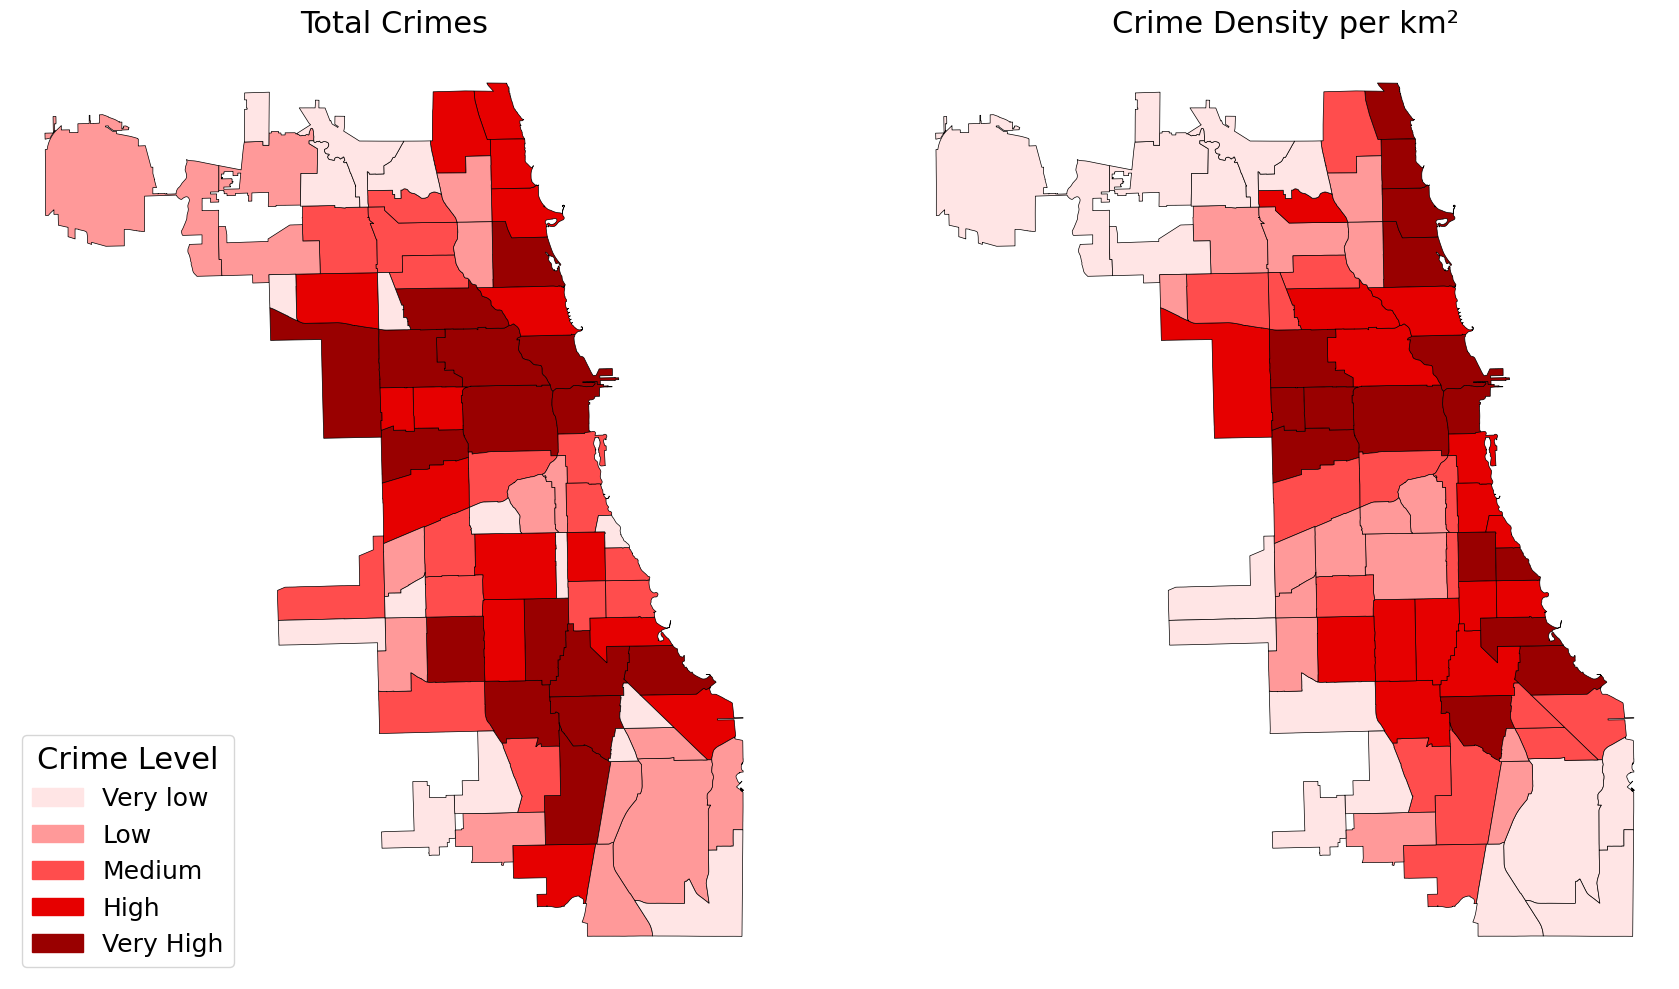

In [16]:
import matplotlib.patches as mpatches


# define color palette depending on the bin (different tones of red)
bin_colors = {
    'Very low': '#ffe5e5',
    'Low': '#ff9999',
    'Medium': '#ff4d4d',
    'High': '#e60000',
    'Very High': '#990000'
}

# Set up side-by-side plots for total crimes and crime density
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# total Crimes plot
crime_counts.plot(
    ax=axes[0],
    color=crime_counts['total_crimes_bin'].map(bin_colors),
    edgecolor='black',
    linewidth=0.5
)
axes[0].set_title("Total Crimes", fontsize=22)
axes[0].axis('off')
# add manual legend
patches = [
    mpatches.Patch(color=color, label=label) 
    for label, color in bin_colors.items()
]
axes[0].legend(
    handles=patches, 
    title="Crime Level", 
    loc="lower left",
    fontsize=18,
    title_fontsize=22
)

# crime density plot
crime_counts.plot(
    ax=axes[1],
    color=crime_counts['crime_density_bin'].map(bin_colors),
    edgecolor='black',
    linewidth=0.5
)
axes[1].set_title("Crime Density per km²", fontsize=22)
axes[1].axis('off')

# Display the plots
plt.tight_layout()
plt.show()

From the plot above, we can observe that computing the crime density creates significant differences in the color mapping of the community areas, when compared to simply considering total crimes. This allows us to evaluate both large and small areas on a level playing field, and as a result the color-coded distribution between community areas looks much more smoother on the right, with clearly-identifiable clusters of high and low crime regions.

When comparing these clusters of community areas with similar crime rates to the [Chicago Neighborhoods mapping](https://chicagoneighborhoodwalks.com/the-neighborhood-walks/), we can observe various similarities:
* The 'Far North Side' on top of the map is mostly distinguishable by its low crime density rates.
* The 'West Side' neighborhood also coincides with the cluster of very high crime density around the middle of the city.
* The 'Far Southeast Side' is also mostly distinguishable by its very low crime rates.

Perhaps the biggest exception to these patterns are the high to very-high crime rates all along the bay area, independently of the neighborhood. This is possibly due to a higher concentration of people on these areas, as shores are typically points of interest in cities that people enjoy visiting.


#### Global Spatial Autocorrelation

In this part, we want to know whether the clustering tendencies we identified for the crime density map are statistically significant. That is, whether spatial autocorrelation exists in our dataset at a global level or not.

One of the most-used statistics for this purpose is **Global Moran's I**, which is expressed as:

\begin{equation}
I = \frac{n}{W} \cdot \frac{\sum_{i=1}^{n}\sum_{j=1}^{n} w_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
\end{equation}

Where:

\begin{align*}
n & = \text{number of spatial units in the map (e.g., community areas)} \\
x_i, x_j & = \text{values of the target variable at locations } i \text{ and } j \\
\bar{x} & = \text{mean of the target variable } x \\
w_{ij} & = \text{Spatial weights between } i \text{ and } j \\
W & = \sum_{i=1}^{n} \sum_{j=1}^{n} w_{ij} \quad \text{(Total sum of Spatial Weights in the dataset)}
\end{align*}

Our target variable in this case is the crime density, which is defined as total crimes per square meter, defined at the community area level.

So far, we haven't touched on spatial weights (**W** in the equation), so let's do it now. Simply put, a **spatial weights matrix** is an adjacency matrix that stores information about the relationship between the different spatial units in a dataset.

In our case, we want to fill the spatial weights matrix with binary encodings for contiguity, meaning we consider as neighbours community areas that share a common border. For this, we employ the _Queen_ contiguity rule, which borrows from the direction in which the queen moves in chess: vertically, horizontally and diagonally. Other chess-based rules are _Rook_ and _Bishop_, which are more restrictive than _Queen_.

Other types of relations include distance-based metrics in a specified influence radius (with or without kernel decay), common membership to a given group (for example, neighborhood membership in our case), or hybrid approaches that combine two or more of these methods.

In [17]:
from libpysal.weights import Queen

# set comm area code as index to crimes df
crime_counts = crime_counts.sort_values("area_number").drop_duplicates("area_number")
crime_counts = crime_counts.set_index("area_number")

# compute SWM
W = Queen.from_dataframe(
    crime_counts, 
    use_index=True
)

# check that implementation was correct
print(
    f"Islands on the dataset (no neighbors): {W.islands}"
)
print("Neighbors mappings: ")
W.neighbors

Islands on the dataset (no neighbors): []
Neighbors mappings: 


{'1': ['2', '77'],
 '10': ['76', '12', '9', '11'],
 '11': ['12', '10', '15'],
 '12': ['10', '15', '14', '16', '11', '13'],
 '13': ['2', '12', '4', '14'],
 '14': ['12', '5', '15', '16', '4', '13'],
 '15': ['12', '19', '14', '16', '20', '17', '11'],
 '16': ['12', '5', '15', '14', '4', '21', '20'],
 '17': ['76', '18', '19', '15'],
 '18': ['19', '25', '17'],
 '19': ['23', '17', '15', '18', '25', '20'],
 '2': ['1', '4', '77', '13'],
 '20': ['23', '19', '15', '16', '25', '21', '22'],
 '21': ['16', '5', '22', '20'],
 '22': ['23', '5', '24', '7', '21', '20'],
 '23': ['19', '27', '24', '26', '25', '22', '20'],
 '24': ['23', '28', '27', '8', '7', '22'],
 '25': ['23', '19', '29', '18', '26', '20'],
 '26': ['23', '25', '29', '27'],
 '27': ['23', '28', '29', '24', '26'],
 '28': ['33', '32', '29', '27', '24', '8', '31', '34'],
 '29': ['28', '30', '27', '26', '31', '25'],
 '3': ['5', '4', '77', '6'],
 '30': ['58', '29', '56', '57', '31', '59'],
 '31': ['58', '60', '28', '33', '30', '29', '34', '59'],

The spatial weights matrix is indexed by the community area code, and it contains no islands, a.k.a areas that share no common borders with others and therefore would have no neighbours. We can go even further to ensure the matrix is well-built and plot the relationships from the matrix:

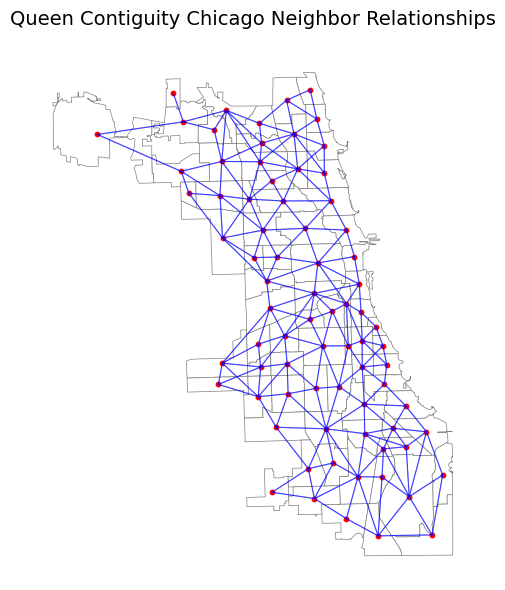

In [18]:
from shapely.geometry import LineString

# switch to projected CRS
projected = crime_counts.to_crs(epsg=3435)
# get centroid for each comm area
projected["centroid"] = projected.geometry.centroid

# define empty plot
fig, ax = plt.subplots(figsize=(8, 6))

projected.plot(  # plot polygons
    ax=ax, 
    edgecolor='gray', 
    facecolor='white', 
    linewidth=0.5
)
projected.set_geometry(  # plot centroids
    "centroid").plot(
        ax=ax, 
        color='red',
        markersize=10
)

# draw lines to represent relationships
for i, neighbors in W.neighbors.items():
    centroid_i = projected.loc[i, "centroid"]
    for j in neighbors:
        centroid_j = projected.loc[j, "centroid"]
        line = LineString([centroid_i, centroid_j])
        ax.plot(*line.xy, color="blue", linewidth=0.8, alpha=0.5)

# formatting
ax.set_title("Queen Contiguity Chicago Neighbor Relationships", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

The resulting mappings indicate the contiguity rule was correctly applied, as each community area is given a relationship to other areas with common borders. There's an empty space near the O'Hare community area, which isn't a bug, but is actually a real area of Chicago that isn't assigned to any districts.

Now we can calculate the Moran's I global statistic with help from the `esda` package:

Moran's I statistic: 0.509
Expected I under spatial randomness: -0.013157894736842105
p-value (simulation-based): 0.001
p-value (under normal dist assumptions): 3.882689610905055e-13


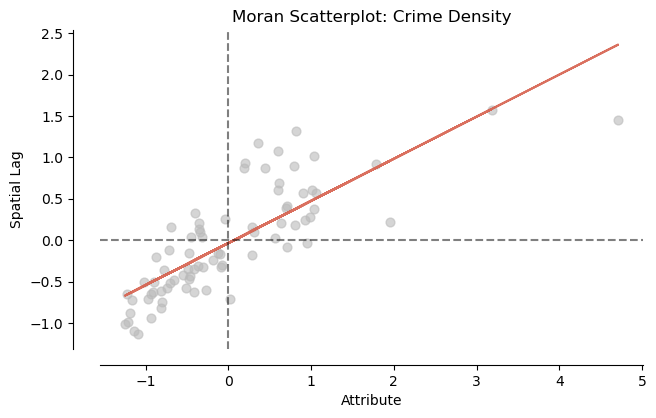

In [19]:
from esda.moran import Moran
from splot.esda import moran_scatterplot


# row-standardize the WSM for compatibility + select target variable
W.transform = 'R'
x = crime_counts["crime_density"]

# calculate Global Moran's I (and other metrics)
moran = Moran(x, W)

# print results
print(f"Moran's I statistic: {round(moran.I, 3)}")
print(f"Expected I under spatial randomness: {moran.EI}")
print(f"p-value (simulation-based): {moran.p_sim}")
print(
    f"p-value (under normal dist assumptions): {moran.p_norm}"
)

# Moran's plot
fig, ax = moran_scatterplot(moran)
ax.set_title("Moran Scatterplot: Crime Density")
plt.show()

The previous cell contains a lot of information, so let's break it down a little:

* The results for the Global Moran’s I statistic were of 0.509, which indicates a positive spatial autocorrelation in the distribution of the target variable (e.g., crime density). This means that community areas with similar crime density values tend to be located next to each other (high-crime areas cluster near other high-crime areas, and viceversa).

* The expected Moran’s I under the null hypothesis of complete spatial randomness is approximately -0.013, suggesting that the observed value is substantially higher than what would be expected by chance.

* To assess the significance of the statistic, both an analytical p-value and a simulation-based p-value were calculated. Without going into much detail about either method, both results are extremely low, indicating that the observed clustering is almost certainly not the result of random chance.

As for the Moran plot, this is another way of visualizing what we've seen with the statistics. It shows on the x-axis the normalized values of crime density of a given community area (by subtracting the median), and on the y axis the average normalized crime density value for the observation's neighbors. 

In the case of positive spatial autocorrelation, you would expect seeing higher concentrations of values around the first and third quadrants, which would represent that similar crime density values tend to go near each other, regardless of it being high or low, and this is precisely the behavior observed on the plot. The I statistic is actually the slope of the Moran Plot, which helps further understand the interpretation of this value further than just that rather extense formula we saw at the beginning.

#### Local Spatial Autocorrelation

Global spatial autocorrelation statistics can tell us whether a map tends to cluster groups of similar values together and to what degree it does so, but it can't tell us where those clusters are. That's where we turn to **local spatial autocorrelation**.

A consistent person would choose to use **Local Moran's I_i** for this part, but I find that the **Gettis-Ord Gi star** statistic is more convenient for this specific use case, because it differentiates the hotspots (high crime densities) from the coldspots (low crime densities).

This statistic is defined the following way:

\begin{equation}
G_i^* = \frac{
    \sum_{j=1}^{n} w_{ij} x_j - \bar{X} \sum_{j=1}^{n} w_{ij}
}{
    S \sqrt{ \frac{ n \sum_{j=1}^{n} w_{ij}^2 - \left( \sum_{j=1}^{n} w_{ij} \right)^2 }{n - 1} }
}
\tag{2}
\end{equation}

Where:
\begin{align*}
n & = \text{number of spatial units in the map (e.g., community areas)} \\
x_j & = \text{value of the target variable at location } j \\
\bar{x} & = \text{mean of the target variable } x \\
w_{ij} & = \text{Spatial weights between } i \text{ and } j \\
S & = \text{Standard deviation of all } x_j \text{ values }
\end{align*}

This equation is a little more complex, and a full explanation of what it does exactly is beyond the scope of this project. For now, what's important to know is that this statistic must be calculated for every spatial unit (community area) in the dataset, and each unit has:
* A standardized Gi* score, which indicates a hotspot (high values for the target variable) if it's greater than 0, and a coldspot (low values for target variable) if it's lower than 0
* A simulation p-value, to discard non-significant clusters

In [20]:
from esda.getisord import G_Local
from libpysal.weights import fill_diagonal


W = Queen.from_dataframe(  # re-initialize weights matrix without normalization
    crime_counts, 
    use_index=True
)
W = fill_diagonal(  # consider relation to self when computing statistic
    W, 
    val=1.0
)
# get Gi* statistic
g_star = G_Local(crime_counts["crime_density"], W, star=True)

Unfortunately, the **Gettis-Ord statistic** doesn't include native `splot` support for graphic visualizations (that I know of), so it's necessary to create it from scratch. This part borrows heavily from the "Local Spatial Autocorrelation" chapter of the book I mention in the introduction.

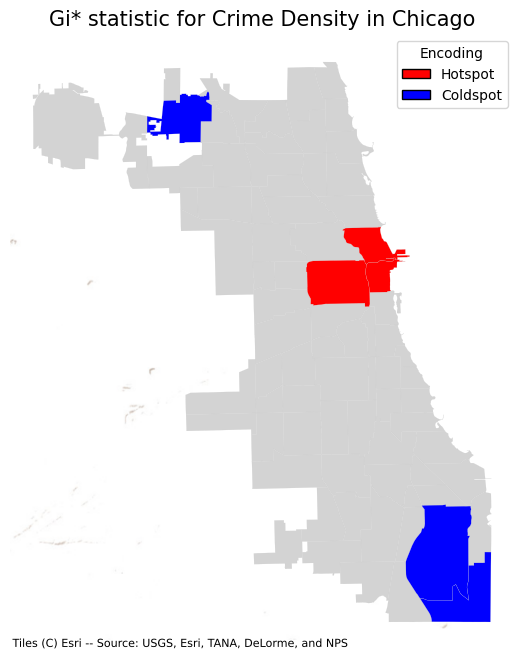

In [21]:
import contextily
from matplotlib.patches import Patch


# initialize plot
fig, ax = plt.subplots(figsize=(8, 8))
# boolean mask for statistical significance
sig = g_star.p_sim < 0.01

# Plot non-significant clusters in gray
ns = crime_counts.loc[sig == False, "geometry"]
ns.plot(ax=ax, color="lightgrey", edgecolor="0.8", linewidth=0.1)

# Plot hotspot clusters in red
hh = crime_counts.loc[(g_star.Zs > 0) & (sig == True), "geometry"]
hh.plot(ax=ax, color="red", edgecolor="0.8", linewidth=0.1)

# Plot coldspot clusters in blue
ll = crime_counts.loc[(g_star.Zs < 0) & (sig == True), "geometry"]
ll.plot(ax=ax, color="blue", edgecolor="0.8", linewidth=0.1)

# style and draw
contextily.add_basemap(
    ax,
    crs=crime_counts.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax.set_title(f"Gi* statistic for Crime Density in Chicago", size=15)
ax.set_axis_off()

# define custom legend elements
# Define custom legend elements
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Hotspot'),
    Patch(facecolor='blue', edgecolor='black', label='Coldspot')
]
plt.legend(handles=legend_elements, title="Density Levels")

# Add the custom legend to your plot
plt.legend(handles=legend_elements, title="Encoding")
plt.show()

The plot summarizes the regions on the map found to have statistically-significant Gi* statistics, which yields similar results to the findings from the choropleth mapping section. Both the Far Southeast and the Farth Northeast sides exhibit clusters of very low crime densities when compared to the rest of the city, while a single cluster of high crime densities is spotted around the West Side neighborhood.

It's important to note that the p-values used for significance are obtained from simulations, not from actual statistical tests, which means they are not deterministic and are subject to change. In order to control this aspect, I chose to be stricter with a p-value of just 0.01 to plot the clusters.

#### Kernel Density Estimation (KDE)

So far, working with crimes grouped at the community area level has been very convenient to simplify the calculations and obtain quick, understandable results. While working with direct events is technically possible in either method, for this case it would have involved computing a 200k by 200k spatial weights matrix with more complex adjacency rules, which would have greatly increased computational cost.

While dividing the map in subregions is helpful to simplify visualizations, it can sometimes be restrictive. What if a true hotspot lies at the intersection of two or more districts, and can't be caught properly using the regular divisions? Here's where more flexible methods like **Kernel Density Estimation** come in.

KDE isn't technically a spatial autocorrelation technique, but it can be used for very similar purposes. It's a non-parametric method for estimating the probability density function for an observed distribution of points in a space (in our case, two-dimensional).

For a univariate distribution, the KDE equation takes on the general form of:

\begin{equation}
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} k\left( \frac{x - x_i}{h} \right)
\tag{3}
\end{equation}

Where the key parameters to understand are:
\begin{align*}
K & = \text{the Kernel function} \\
h & = \text{The bandwidth}
\end{align*}

* The Kernel function determines the general "shape" of the curve and the way it fits the data. A Gaussian kernel creates smooth, bell-shaped curves, while others like the triangular kernel may create more clunky shapes

* The bandwidth defines the smoothing of the function. For lower values the smoothing is low, so the curve fits the data more closely, while at higher values it becomes much more even and general.

Choosing the correct bandwidth is a tradeoff between variance and bias. The goal is to have a final pdf (probability density function) that closely approximates the true distribution's behavior without overfitting on particular details.

For specialized applications, the ideal bandwidth can be found by generating an array of possible values and testing them using cross validation, following a method like this:
* Choose a fixed Kernel function. Gaussian is one of the most used
* Split the data on training and test splits
* Use the training data to generate the pdf using the KDE
* Evaluate the log-likelihood of observing the test data given the estimated pdf, and repeat for the other validation splits

The bandwidth which maximizes the average log-likelihood through all the training splits is the best choice. 

For most applications, however, simple rules of thumb are enough to estimate the bandwidth. Without going into detail, these rules take into account the number of data points and dimensions of the data, among other variables and come up with a one-size-fits-all estimation of a bandwidth that generally yields pretty decent results.

The current KDE application differs somewhat from the basics mentioned above. The crime events follow a bivariate distribution, as they have coordinates in a two-dimensional space. Also, [Scott's rule](https://en.wikipedia.org/wiki/Scott%27s_rule) will be used to estimate the bandwidth.

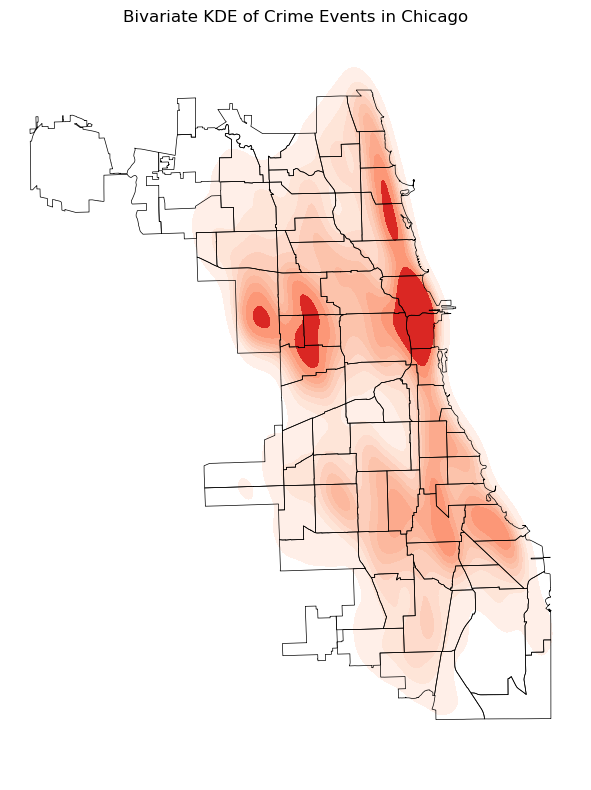

In [31]:
# re-project events to new crs and extract x and y coordinates
projected_events = events_data.to_crs(epsg=3435)
projected_events = projected_events.sample(  # keep 15k random obs
    n=15000, 
    random_state=34
)
projected_events["x"] = projected_events.geometry.x
projected_events["y"] = projected_events.geometry.y

# define fig and axis
f, ax = plt.subplots(1, figsize=(8, 8))

# KDE plot
sns.kdeplot(
    data=projected_events,
    x="x",
    y="y",
    fill=True,
    cmap="Reds",
    bw_adjust=0.7,  # adjust the granularity for the kde (< 1 means less bw)
    bw_method="scott",  # choose Scott's rule
    ax=ax
)

# base: plot the community areas
projected_com_areas.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.5
)
# additional params
ax.set_axis_off()
ax.set_title("Bivariate KDE of Crime Events in Chicago")
plt.tight_layout()
plt.show()

The plot above shows a very intuitive and smooth visualization of crime hotspots on the city of Chicago, free from the limitations of restricting the crime's location to its community area.

It has some points in common with the choropleth map and the visualization for the Gettis-Ord clusters, which helps confirm those findings. In all of them the Far North Side and the Far Southeast neighborhoods have low concentrations of crime, while the region around the West Side presents the highest concentrations overall.

However, this map also extends the previous two in some aspects, providing new information. Its main advantage is to plot a more flexible shape for the true hotspots present in the data. The biggest one is the oval-shaped cluster around the Central Chicago neighborhood (next to the bay area), which extends to five different community areas. It also shows three more crime hotspots, which weren't caught by the Gi* probably due to their small and irregular size that wasn't properly contained by the community area delimitations.

--------------
### Final Thoughts

In this notebook we touched on some key principles for conducting a preliminary analysis of a geographical data. One of the key takeaways, in my opinion, is that combining different techniques, each one with different underlying assumptions and theory but all aimed towards a common target helps extract more solid and trustworthy insights from the data than what would be possible with just one method. 

For example, finding the local crime hotspots wouldn't have been much use if it turned out that the data didn't have statistically-significant SA. Likewise, determining the clusters from the community area divisions would have led to incorrect assumptions about the true shape of the clusters.

This is all for now, thank you for your time :)